In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ac3airborne
import typhon as ty
import os
import src
import datetime
from dotenv import load_dotenv
import pandas as pd

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [2]:
load_dotenv(dotenv_path='/home/mringel/lwp_project/code/.env')

# needed for data stored in AC3 cloud
ac3cloud_username = os.environ['AC3_USER']
ac3cloud_password = os.environ['AC3_PASSWORD']

credentials = dict(user=ac3cloud_username, password=ac3cloud_password)

cat = ac3airborne.get_intake_catalog() # intake catalogues
meta = ac3airborne.get_flight_segments() # flight segmentation

In [4]:
lwp_campaign_p5 = xr.open_dataset('/net/secaire/mringel/data/lwp_retrieved/all_campaigns_P5_lwp_v3.nc')
lwp_campaign_era5 = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/all_campaigns_ERA5_lwp.nc')
lwp_campaign_aqua = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_modis/all_campaigns_P5_MODIS_aqua_lwp.nc')
lwp_campaign_terra = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_modis/all_campaigns_P5_MODIS_terra_lwp.nc')
lwp_campaign_amsr = xr.open_dataset('/net/secaire/mringel/data/lwp_collocated/lwp_amsr2/all_campaigns_P5_AMSR_lwp.nc')

# drop all NaN values in P5 dataset
lwp_campaign_p5 = lwp_campaign_p5.dropna(dim='time')

lwp_era5_ds = src.get_identical_times(lwp_campaign_era5,lwp_campaign_p5)
lwp_aqua_ds = src.get_identical_times(lwp_campaign_aqua,lwp_campaign_p5)
lwp_terra_ds = src.get_identical_times(lwp_campaign_terra,lwp_campaign_p5)
lwp_amsr_ds = src.get_identical_times(lwp_campaign_amsr,lwp_campaign_p5)

lwp_p5 = lwp_campaign_p5.lwp.values*1000
lwp_era5 = lwp_era5_ds.lwp.values*1000
lwp_aqua = lwp_aqua_ds.lwp.values
lwp_terra = lwp_terra_ds.lwp.values
lwp_amsr = lwp_amsr_ds.lwp.values*1000

lwp_terra[lwp_terra==-9999] = np.nan
lwp_aqua[lwp_aqua==-9999] = np.nan
lwp_amsr[lwp_amsr==-9999] = np.nan

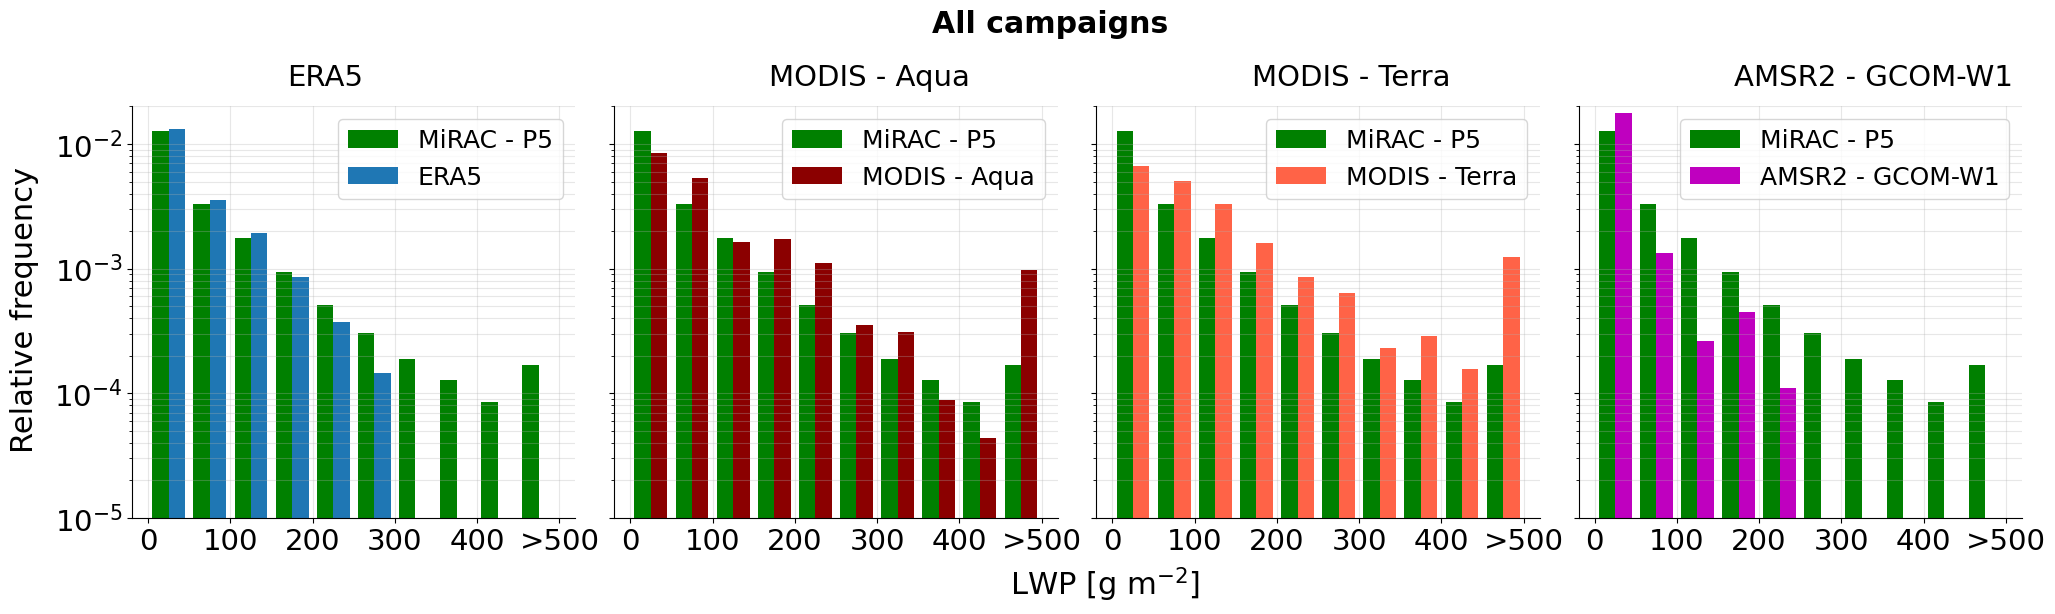

In [12]:
fig, axs = plt.subplots(1,4,figsize=(20,5),sharey=True)

#lwp_range = [-100,500]
#bins = 12
lwp_range = [0,500]
bins = 10

campaigns = list(cat)
del campaigns[1]

datasets = [lwp_era5,lwp_aqua,lwp_terra,lwp_amsr]

collocations_era5 = []
collocations_amsr = []
collocations_aqua = []
collocations_terra = []
for i in range(4):   
    
    labels = ['ERA5','MODIS - Aqua', 'MODIS - Terra','AMSR2 - GCOM-W1']
    colors = ['C0','darkred','tomato','m']

    axs[i].hist([np.clip(lwp_p5,lwp_range[0],lwp_range[1]),np.clip(datasets[i],lwp_range[0],lwp_range[1])],
        density=True,
        histtype='bar',
        color=['green',colors[i]],
        label=['MiRAC - P5',labels[i]],
        stacked=False,
        range=lwp_range,
        bins=bins)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[i].text(0.35,1.05,labels[i],fontsize=21,transform=axs[i].transAxes)

    #axs[i].axvline(x=0,linestyle='dashed',color='black',alpha=0.75)

    axs[i].set_yscale('log')
    axs[i].set_ylim(bottom=10**(-5),top=2*10**(-2))
    axs[i].grid(alpha=0.3,which='both',axis="both")
    axs[i].legend(loc='upper right',fontsize=18)
    #axs[i].set_xticks(np.array([-100,0,100,200,300,400,500]))
    #axs[i].set_xticklabels(np.array([ '<100','0', '100', '200', '300', '400', '>500']))
    axs[i].set_xticks(np.array([0,100,200,300,400,500]))
    axs[i].set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))
    axs[i].tick_params(axis="both", labelsize=21) 


fig.text(-0.02, 0.5,'Relative frequency',rotation=90,fontsize=22,va='center')
fig.text(0.48, -0.05,'LWP [g m$^{-2}$]',fontsize=22,va='center')
fig.suptitle('All campaigns',y=1.1,fontweight='bold')

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/1D_histograms_all_campaigns_v2.png',
            bbox_inches='tight',
            dpi=200)

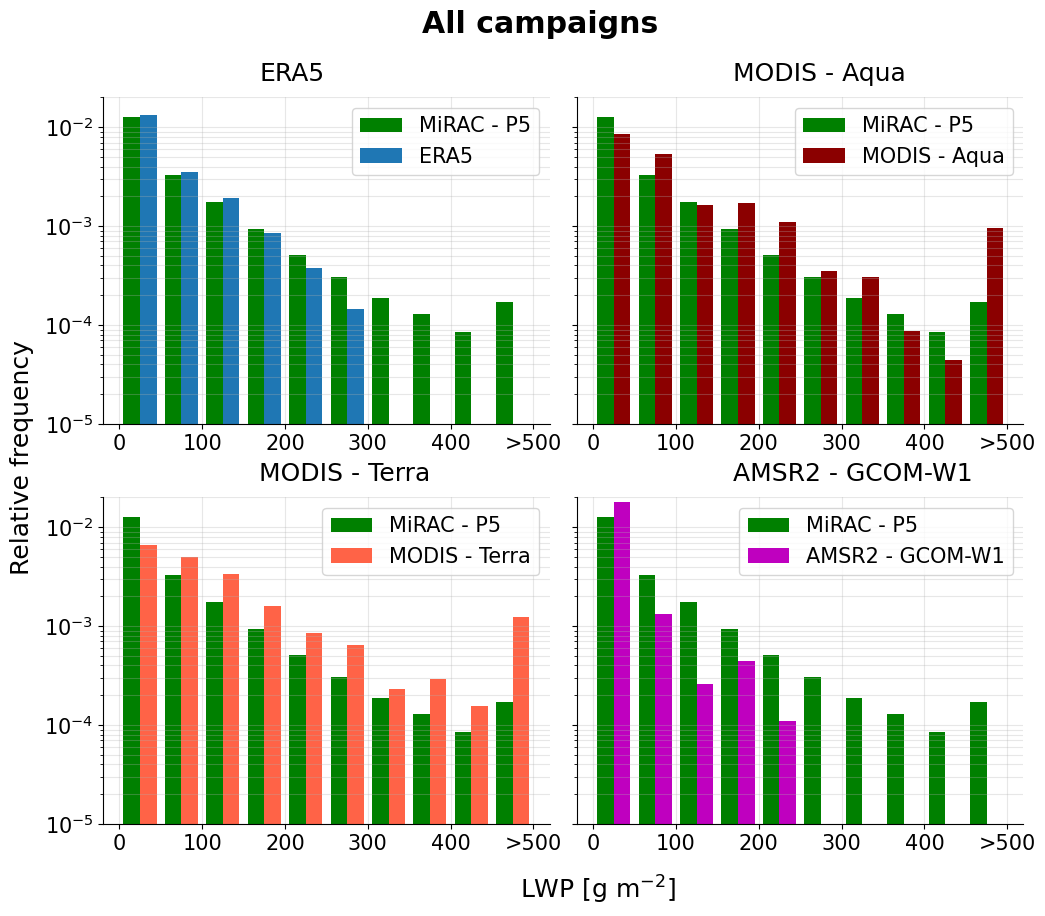

In [7]:
fig, axs = plt.subplots(2,2,figsize=(10,8),sharey=True)

#lwp_range = [-100,500]
#bins = 12
lwp_range = [0,500]
bins = 10

campaigns = list(cat)
del campaigns[1]

datasets = [lwp_era5,lwp_aqua,lwp_terra,lwp_amsr]

labels = ['ERA5','MODIS - Aqua', 'MODIS - Terra','AMSR2 - GCOM-W1']
colors = ['C0','darkred','tomato','m']

counter = 0
for row in range(2): 
    for col in range(2):  
    
        axs[row,col].hist([np.clip(lwp_p5,lwp_range[0],lwp_range[1]),np.clip(datasets[counter],lwp_range[0],lwp_range[1])],
            density=True,
            histtype='bar',
            color=['green',colors[counter]],
            label=['MiRAC - P5',labels[counter]],
            stacked=False,
            range=lwp_range,
            bins=bins)

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        axs[row,col].text(0.35,1.05,labels[counter],transform=axs[row,col].transAxes)

        #axs[row,col].axvline(x=0,linestyle='dashed',color='black',alpha=0.75)

        axs[row,col].set_yscale('log')
        axs[row,col].set_ylim(bottom=10**(-5),top=2*10**(-2))
        axs[row,col].grid(alpha=0.3,which='both',axis="both")
        axs[row,col].legend(loc='upper right')
        axs[row,col].set_xticks(np.array([0,100,200,300,400,500]))
        axs[row,col].set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))
        #axs[row,col].set_xticks(np.array([-100,0,100,200,300,400,500]))
        #axs[row,col].set_xticklabels(np.array([ '<100','0', '100', '200', '300', '400', '>500']))

        counter += 1


fig.text(-0.03, 0.5,'Relative frequency',rotation=90,fontsize=18,va='center')
fig.text(0.48, -0.04,'LWP [g m$^{-2}$]',fontsize=18,va='center')
fig.suptitle('All campaigns',y=1.06,fontweight='bold')

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/1D_histograms_all_campaigns.png',
            bbox_inches='tight',
            dpi=200)

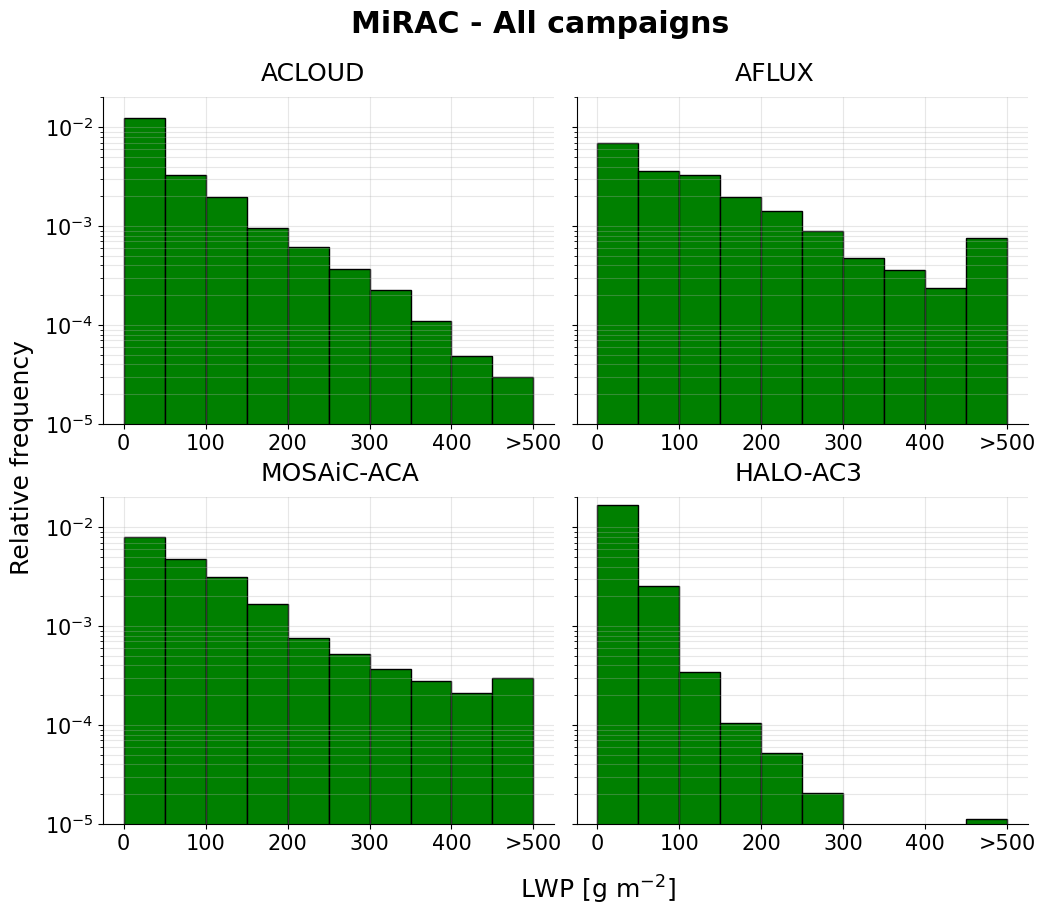

In [28]:
fig, axs = plt.subplots(2,2,figsize=(10,8),sharey=True)

#lwp_range = [-100,500]
#bins = 12
lwp_range = [0,500]
bins = 10

campaigns = list(cat)
del campaigns[1]
del campaigns[-1]

counter = 0
for row in range(2): 
    for col in range(2):  

        
        flight_dates = [meta[campaigns[counter]]['P5'][flight_id]['date'] for flight_id in list(cat[campaigns[counter]]['P5']['MiRAC-A'])]

        lwp_p5_ds = lwp_campaign_p5.sel(time=slice(flight_dates[0],flight_dates[-1]))
        lwp_p5 = lwp_p5_ds.lwp.values*1000
    
        axs[row,col].hist(np.clip(lwp_p5,lwp_range[0],lwp_range[1]),
            density=True,
            histtype='bar',
            color='green',
            stacked=False,
            ec='black',
            range=lwp_range,
            bins=bins)

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        axs[row,col].text(0.35,1.05,campaigns[counter],transform=axs[row,col].transAxes)

        #axs[row,col].axvline(x=0,linestyle='dashed',color='black',alpha=0.75)

        axs[row,col].set_yscale('log')
        axs[row,col].set_ylim(bottom=10**(-5),top=2*10**(-2))
        axs[row,col].grid(alpha=0.3,which='both',axis="both")
        axs[row,col].set_xticks(np.array([0,100,200,300,400,500]))
        axs[row,col].set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))
        #axs[row,col].set_xticks(np.array([-100,0,100,200,300,400,500]))
        #axs[row,col].set_xticklabels(np.array([ '<100','0', '100', '200', '300', '400', '>500']))

        counter += 1


fig.text(-0.03, 0.5,'Relative frequency',rotation=90,fontsize=18,va='center')
fig.text(0.48, -0.04,'LWP [g m$^{-2}$]',fontsize=18,va='center')
fig.suptitle('MiRAC - All campaigns',y=1.06,fontweight='bold')

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/histogram_all_campaigns_only_MiRAC.png',
            bbox_inches='tight',
            dpi=200)

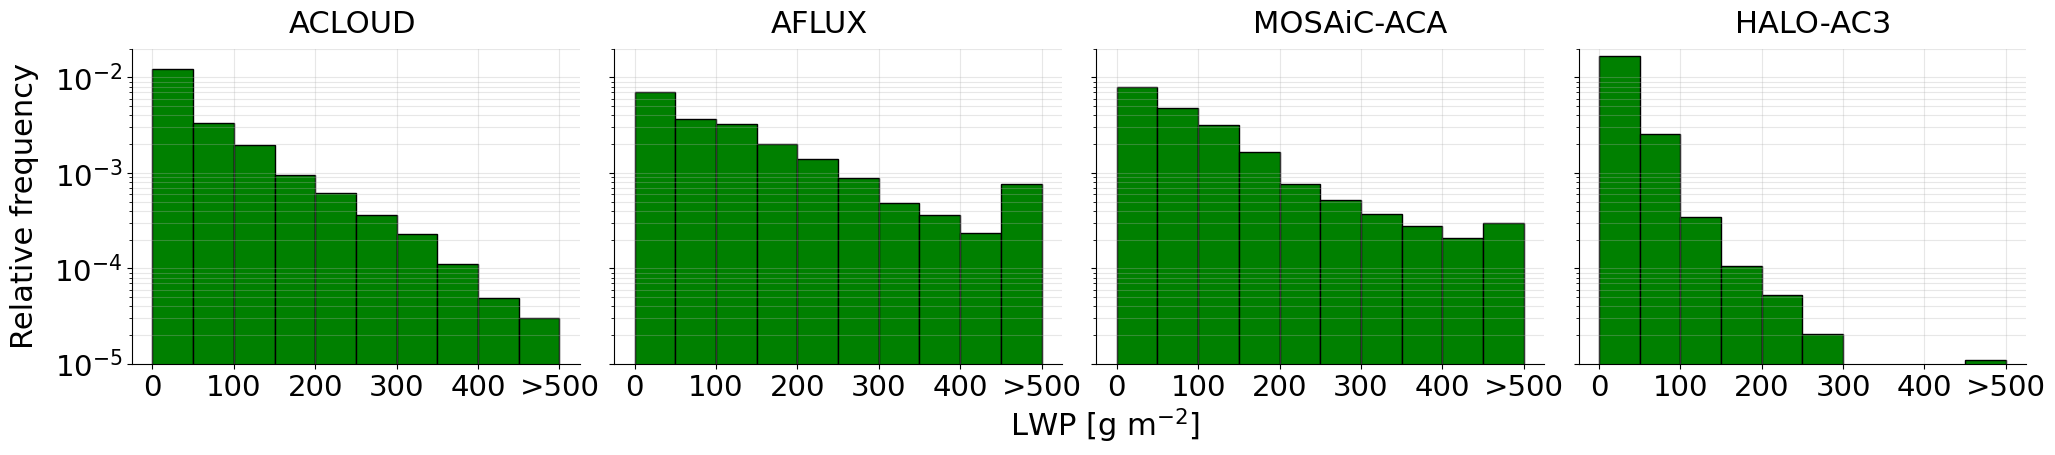

In [15]:
fig, axs = plt.subplots(1,4,figsize=(20,4),sharey=True)

#lwp_range = [-100,500]
#bins = 12
lwp_range = [0,500]
bins = 10

campaigns = list(cat)
del campaigns[1]
del campaigns[-1]

for col in range(4): 
    
    flight_dates = [meta[campaigns[col]]['P5'][flight_id]['date'] for flight_id in list(cat[campaigns[col]]['P5']['MiRAC-A'])]

    lwp_p5_ds = lwp_campaign_p5.sel(time=slice(flight_dates[0],flight_dates[-1]))
    lwp_p5 = lwp_p5_ds.lwp.values*1000
    
    axs[col].hist(np.clip(lwp_p5,lwp_range[0],lwp_range[1]),
            density=True,
            histtype='bar',
            color='green',
            stacked=False,
            ec='black',
            range=lwp_range,
            bins=bins)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[col].text(0.35,1.05,campaigns[col],fontsize=22,transform=axs[col].transAxes)

    #axs[col].axvline(x=0,linestyle='dashed',color='black',alpha=0.75)

    axs[col].set_yscale('log')
    axs[col].set_ylim(bottom=10**(-5),top=2*10**(-2))
    axs[col].grid(alpha=0.3,which='both',axis="both")
    axs[col].set_xticks(np.array([0,100,200,300,400,500]))
    axs[col].set_xticklabels(np.array(['0', '100', '200', '300', '400', '>500']))
    #axs[col].set_xticks(np.array([-100,0,100,200,300,400,500]))
    #axs[col].set_xticklabels(np.array([ '<100','0', '100', '200', '300', '400', '>500']))
    axs[col].tick_params(axis="both", labelsize=21) 


fig.text(-0.02, 0.5,'Relative frequency',rotation=90,fontsize=22,va='center')
fig.text(0.48, -0.05,'LWP [g m$^{-2}$]',fontsize=22,va='center')
fig.suptitle('MiRAC - All campaigns',y=1.1,fontweight='bold')

plt.savefig('/home/mringel/lwp_project/figures/figures4poster/histogram_all_campaigns_only_MiRAC_v2.png',
            bbox_inches='tight',
            dpi=200)

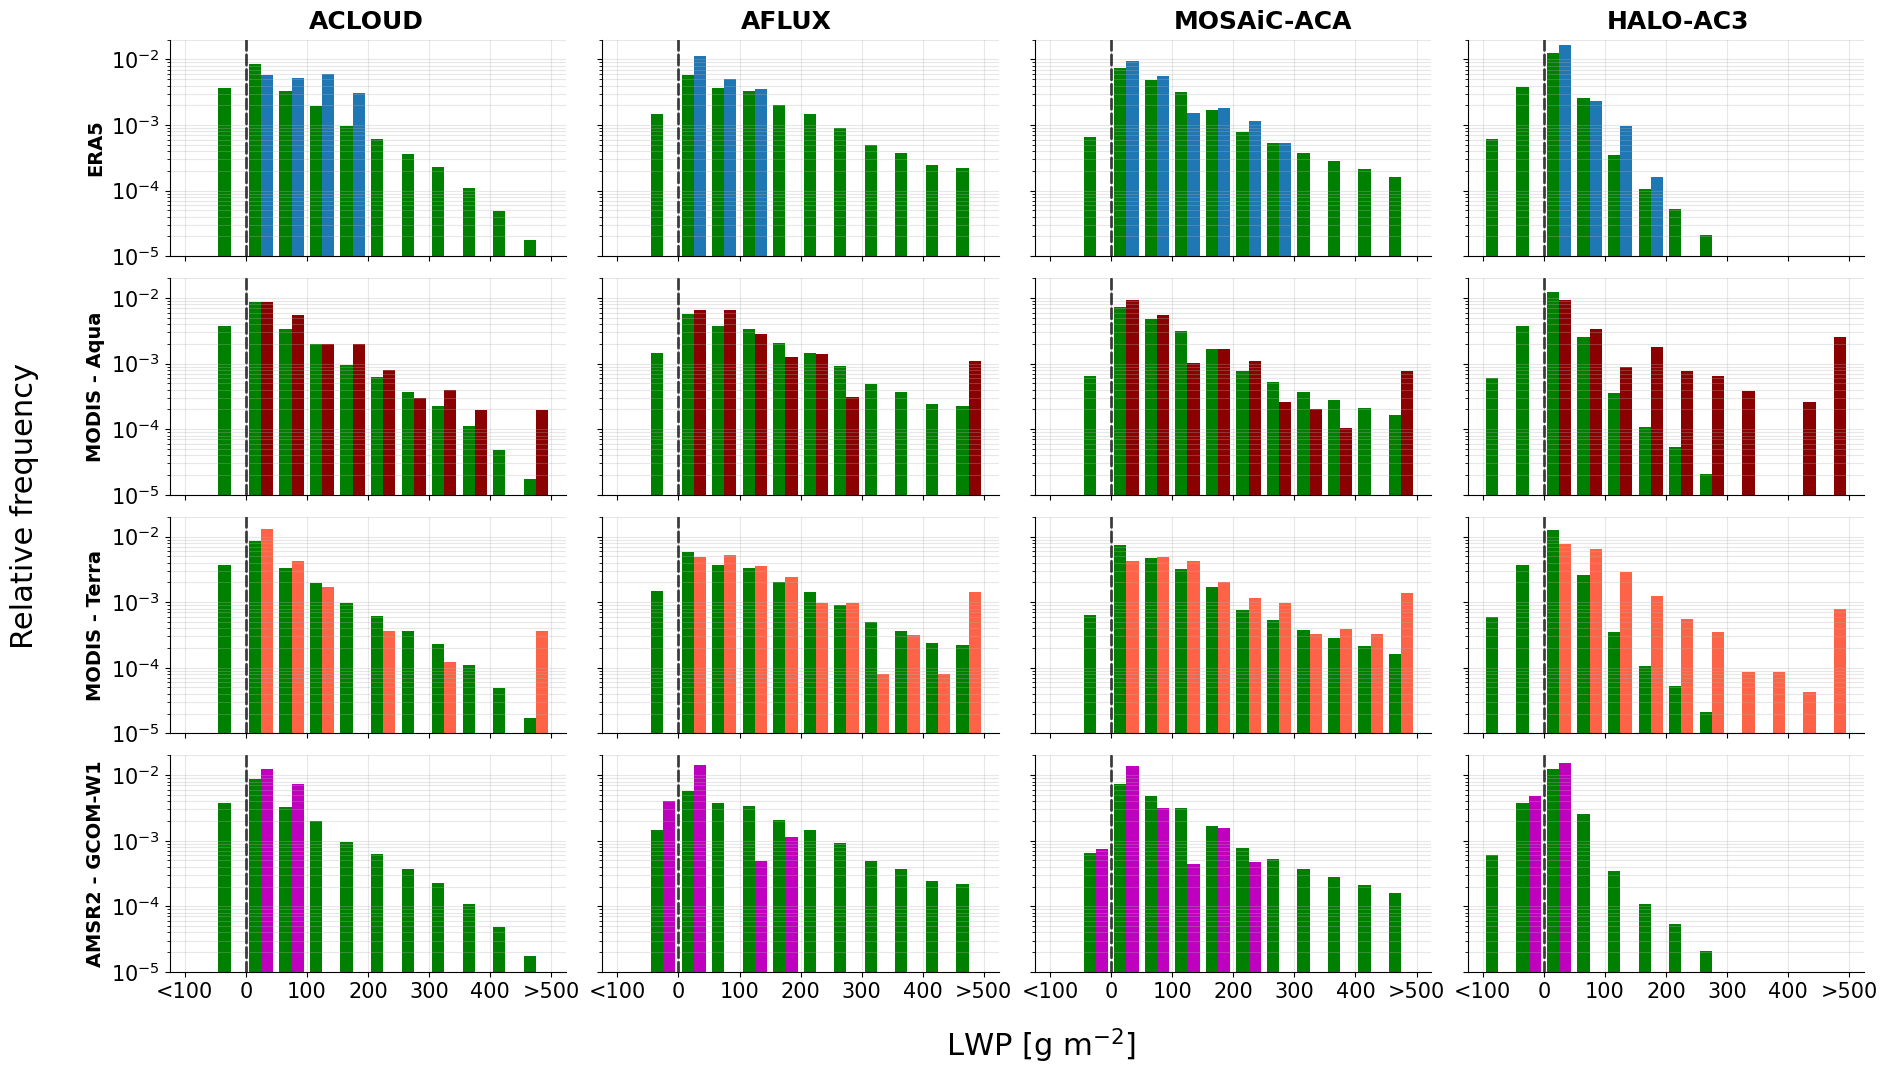

In [13]:
fig, axs = plt.subplots(4,4,figsize=(18,10),sharey=True,sharex=True)

lwp_range = [-100,500]
bins = 12

campaigns = list(cat)
del campaigns[1]

collocations_era5 = []
collocations_amsr = []
collocations_aqua = []
collocations_terra = []

for row in range(4):
    for col, campaign in enumerate(campaigns):   
        
        if campaign == "HAMAG": continue
        
        flight_dates = [meta[campaign]['P5'][flight_id]['date'] for flight_id in list(cat[campaign]['P5']['MiRAC-A'])]

        lwp_p5_ds = lwp_campaign_p5.sel(time=slice(flight_dates[0],flight_dates[-1]))
        lwp_aqua_ds = lwp_campaign_aqua.sel(time=slice(flight_dates[0],flight_dates[-1]))
        lwp_terra_ds = lwp_campaign_terra.sel(time=slice(flight_dates[0],flight_dates[-1]))
        lwp_era5_ds = lwp_campaign_era5.sel(time=slice(flight_dates[0],flight_dates[-1]))
        lwp_amsr_ds = lwp_campaign_amsr.sel(time=slice(flight_dates[0],flight_dates[-1]))

        lwp_era5_ds = src.get_identical_times(lwp_era5_ds,lwp_p5_ds)
        lwp_aqua_ds = src.get_identical_times(lwp_aqua_ds,lwp_p5_ds)
        lwp_terra_ds = src.get_identical_times(lwp_terra_ds,lwp_p5_ds)
        lwp_amsr_ds = src.get_identical_times(lwp_amsr_ds,lwp_p5_ds)

        lwp_p5 = lwp_p5_ds.lwp.values*1000
        lwp_era5 = lwp_era5_ds.lwp.values*1000
        lwp_aqua = lwp_aqua_ds.lwp.values
        lwp_terra = lwp_terra_ds.lwp.values
        lwp_amsr = lwp_amsr_ds.lwp.values*1000

        lwp_terra[lwp_terra==-9999] = np.nan
        lwp_aqua[lwp_aqua==-9999] = np.nan
        lwp_amsr[lwp_amsr==-9999] = np.nan

        datasets = [lwp_era5,lwp_aqua,lwp_terra,lwp_amsr]

        labels = ['ERA5','MODIS - Aqua', 'MODIS - Terra','AMSR2 - GCOM-W1']
        colors = ['C0','darkred','tomato','m']

        _,bins,_ = axs[row,col].hist([lwp_p5,np.clip(datasets[row],lwp_range[0],lwp_range[1])],
            density=True,
            histtype='bar',
            color=['green',colors[row]],
            label=labels,
            stacked=False,
            range=lwp_range,
            bins=bins)

        
        if row == 3:
            axs[row,col].set_xticks(np.array([-100,0,100,200,300,400,500]))
            axs[row,col].set_xticklabels(np.array([ '<100','0', '100', '200', '300', '400', '>500']))

        collocations_era5.append(len(lwp_era5[~np.isnan(lwp_era5)]))
        collocations_amsr.append(len(lwp_amsr[~np.isnan(lwp_amsr)]))
        collocations_aqua.append(len(lwp_aqua[~np.isnan(lwp_aqua)]))
        collocations_terra.append(len(lwp_terra[~np.isnan(lwp_terra)]))

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

        axs[row,col].axvline(x=0,linestyle='dashed',color='black',alpha=0.75)
        axs[row,col].set_yscale('log')
        axs[row,col].set_ylim(bottom=10**(-5),top=2*10**(-2))
        axs[row,col].grid(alpha=0.3,which='both',axis="both")

        if row == 0:
            axs[row,col].text(0.35,1.05,campaigns[col],fontweight='bold',transform=axs[row,col].transAxes)
        if col == 0:
            axs[row,col].set_ylabel(labels[row],fontweight='bold',fontsize=14)
        
        #handles, labels = axs[row,col].get_legend_handles_labels()

#lgd = fig.legend(handles, labels, prop={'size': 16}, loc='lower center', ncol=5, bbox_to_anchor=(0.53,-0.225))
fig.text(-0.04, 0.5,'Relative frequency',rotation=90,fontsize=22,va='center')
fig.text(0.48, -0.04,'LWP [g m$^{-2}$]',fontsize=22,va='center')

plt.savefig('/home/mringel/lwp_project/figures/histograms/histogram_all_campaigns_individually_v4_logscale.png',
            bbox_inches='tight',
            dpi=200)